<a href="https://colab.research.google.com/github/TTD-JPO/TDD-project/blob/jedi3/Main_TweetDisasterDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Twitter Disaster Detection

<center>

# Load Libs & Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import timedelta, time

In [ ]:
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

In [ ]:
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score, plot_confusion_matrix

from sklearn.naive_bayes import CategoricalNB, MultinomialNB, BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [ ]:
import re
import string
import nltk

nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import STOPWORDS

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


[Link to data (csv) @google drive](https://drive.google.com/file/d/1QPragNh_wYQVsXQvds8sqjDMfzARD638/view?usp=sharing)


In [ ]:
url = 'https://raw.githubusercontent.com/TTD-JPO/TDD-project/main/disaster_tweets.csv'
disaster_tweets = pd.read_csv(url, encoding='latin-1')

# Helper function

In [ ]:
def clean_text(text):
  # get rid of all unwanted punctuation and digits
  text = text.replace("´", "'")

  digi_punct = "[^a-zA-Z' ]"
  text = re.sub(digi_punct, " ", text)
  text = " ".join(text.split())
  text = text.lower()

  return text

def my_df_text_mining(df, col):
  lemmatizer = WordNetLemmatizer()
  my_stopwords = stopwords.words("english")
  
  df["_no_stopwords"] = df[col].apply(             lambda texxt: " ".join([word for word in clean_text(texxt).split() if word not in my_stopwords]))
  df[col]             = df["_no_stopwords"].apply( lambda texxt: " ".join([lemmatizer.lemmatize(word) for word in texxt.split()]) )

  return df.drop(["_no_stopwords"], axis=1)

################################

def my_df_spacy_locgpe(df, col):  
  df["loc_gpe"] = df[col].apply( lambda texxt: " ".join([ ent.text for ent in nlp( clean_text(texxt) ).ents  if ((ent.label_ =='LOC') | (ent.label_ =='GPE'))]) )
  return df

def my_df_spacy_date_time(df, col):
  df["date_time"] = df[col].apply( lambda texxt: " ".join([ ent.text for ent in nlp( clean_text(texxt) ).ents  if ((ent.label_ =='DATE') | (ent.label_ =='TIME'))]) )
  return df

def my_df_spacy_fac(df, col):
  df["FAC"] = df[col].apply( lambda texxt: " ".join([ ent.text for ent in nlp( clean_text(texxt) ).ents  if (ent.label_ =='FAC') ]) )
  return df
################################

def spcy_test(text):
  displacy.render(nlp(clean_text(text)), style='ent', jupyter=True)

################################

def corpus_func(series):
    '''create a text block (corpus) from a series'''
    return " #### ".join(text for text in series)

def corpus_list(corpus):
    '''create a list from text block (corpus)'''
    corpus_list = lambda x: x.split(' #### ')

## Evaluate data

In [ ]:
disaster_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [ ]:
print( "absolute number of disaster indicated messages:", disaster_tweets.target.sum() )
print( f"relative number of disaster indicated messages: {disaster_tweets.target.sum() / disaster_tweets.shape[0] :0.3f}" )

absolute number of disaster indicated messages: 3271
relative number of disaster indicated messages: 0.430


In [ ]:
keys      = list(disaster_tweets.keyword.unique() )
locations = list(disaster_tweets.location.unique() )
print(f'len_keys: {len(keys)}\tlen_locations: {len(locations)}')

len_keys: 222	len_locations: 3342


In [ ]:
disaster_tweets.groupby('keyword').target.count().sort_values(ascending=False)

keyword
fatalities               45
deluge                   42
armageddon               42
body%20bags              41
sinking                  41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: target, Length: 221, dtype: int64

In [ ]:
disaster_tweets.groupby('location').target.count().sort_values(ascending=False)

location
USA                            104
New York                        71
United States                   50
London                          45
Canada                          29
                              ... 
Republica Dominicana             1
Republic of the Philippines      1
Regalo Island                    1
Redondo Beach, CA                1
                                 1
Name: target, Length: 3341, dtype: int64

In [ ]:
display( f"relative number of keyword   messages: {disaster_tweets.keyword.nunique()  / disaster_tweets.shape[0] :0.3f}" )
display( f"relative number of location  messages: {disaster_tweets.location.nunique() / disaster_tweets.shape[0] :0.3f}" )

'relative number of keyword   messages: 0.029'

'relative number of location  messages: 0.439'

In [ ]:
### we might do these steps later after having processed the text :)
#dt = disaster_tweets.copy()

## Visualization of data (of)

In [ ]:
df = disaster_tweets

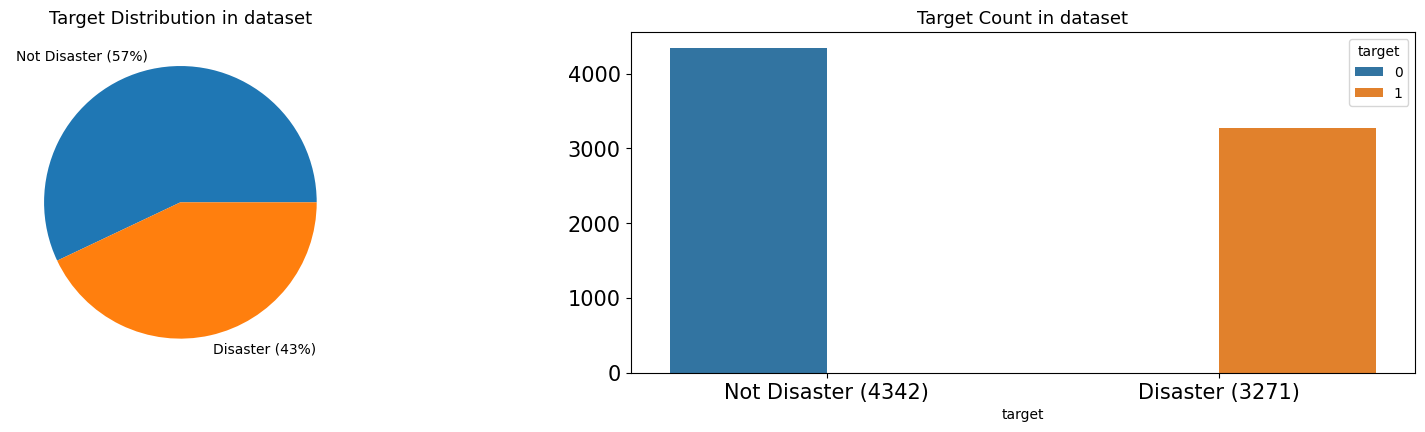

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout()

df.groupby('target').count()['id'].plot(kind='pie', ax=axes[0], labels=['Not Disaster (57%)', 'Disaster (43%)'])
sns.countplot(x=df['target'], hue=df['target'], ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Not Disaster (4342)', 'Disaster (3271)'])
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Target Distribution in dataset', fontsize=13)
axes[1].set_title('Target Count in dataset', fontsize=13)

plt.show()

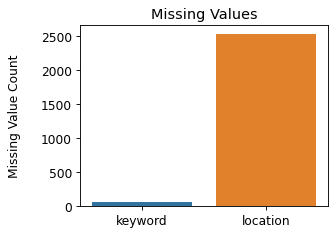

In [ ]:
missing_cols = ['keyword', 'location']

plt.figure(figsize=(4, 3), dpi=80)

sns.barplot(x=disaster_tweets[missing_cols].isna().sum().index, y=disaster_tweets[missing_cols].isna().sum().values)

plt.ylabel('Missing Value Count', size=11, labelpad=18)
plt.tick_params(axis='x', labelsize=11)
plt.tick_params(axis='y', labelsize=11)

plt.title('Missing Values', fontsize=13)

plt.show()

# Cleaning of data 
- df deaster tweets - 'dtt_clean'

In [ ]:
dtt_clean = disaster_tweets.copy()

In [ ]:
dtt_clean = my_df_text_mining(dtt_clean, 'text')

In [ ]:
dtt_clean.head(3)

,id,keyword,location,text,target
0,1,NaN,NaN,deed reason earthquake may allah forgive u,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,resident asked 'shelter place' notified office...,1


### clean NaN

In [ ]:
missing_cols = ['keyword', 'location']
for col in  missing_cols:
    dtt_clean[col] = dtt_clean[col].fillna(f'no_{col}')

In [ ]:
dtt_clean.head(2)

,id,keyword,location,text,target
0,1,no_keyword,no_location,deed reason earthquake may allah forgive u,1
1,4,no_keyword,no_location,forest fire near la ronge sask canada,1


# Analizing tweet < text >
- NLP keyword, localization 

### trail ... (pw)


In [ ]:
#Regex:
dtt_clean['keyword_re'] = dtt_clean.keyword.apply(lambda text: re.sub("%20"," ", text))  # leerzeichen !!!

In [ ]:
# analog to goupby in Evaluate data (but after clean keyword)
# make a count for the keyword list

### zu den libaries wenn codezelle bleiben soll
from collections import Counter


key_count = sorted(Counter(list(dtt_clean['keyword_re'])).items(), key = lambda kv:( kv[1], kv[0]), reverse=True)
print(key_count[0:20])

[('no_keyword', 61), ('fatalities', 45), ('deluge', 42), ('armageddon', 42), ('sinking', 41), ('harm', 41), ('damage', 41), ('body bags', 41), ('windstorm', 40), ('twister', 40), ('siren', 40), ('outbreak', 40), ('fear', 40), ('evacuate', 40), ('collided', 40), ('wrecked', 39), ('wreckage', 39), ('whirlwind', 39), ('weapons', 39), ('weapon', 39)]


In [ ]:
'''
#zu überarbeiten
from nltk.stem import SnowballStemmer

sb_stemmer = SnowballStemmer('english')
dtt_clean['keyword_stem']= dtt_clean["keyword_re"].apply(lambda keyword_re: " ".join([sb_stemmer.stem(word) for word in keyword_re]))
'''

'\n#zu überarbeiten\nfrom nltk.stem import SnowballStemmer\n\nsb_stemmer = SnowballStemmer(\'english\')\ndtt_clean[\'keyword_stem\']= dtt_clean["keyword_re"].apply(lambda keyword_re: " ".join([sb_stemmer.stem(word) for word in keyword_re]))\n'

In [ ]:
corpus_keys = corpus_func(dtt_clean['keyword_re'])

In [ ]:
keyword_low=[x.lower() for x in dtt_clean['keyword_re']]

In [ ]:
dtt_clean['keyword_low'] = keyword_low

In [ ]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

stem_tok ={}
for w in tokens_low: 
    stem_tok[w] = stemmer.stem(w)

stem_tok 

{'ablaze': 'ablaz',
 'accident': 'accid',
 'aftershock': 'aftershock',
 'airplane accident': 'airplane accid',
 'ambulance': 'ambul',
 'annihilated': 'annihil',
 'annihilation': 'annihil',
 'apocalypse': 'apocalyps',
 'armageddon': 'armageddon',
 'army': 'armi',
 'arson': 'arson',
 'arsonist': 'arsonist',
 'attack': 'attack',
 'attacked': 'attack',
 'avalanche': 'avalanch',
 'battle': 'battl',
 'bioterror': 'bioterror',
 'bioterrorism': 'bioterror',
 'blaze': 'blaze',
 'blazing': 'blaze',
 'bleeding': 'bleed',
 'blew up': 'blew up',
 'blight': 'blight',
 'blizzard': 'blizzard',
 'blood': 'blood',
 'bloody': 'bloodi',
 'blown up': 'blown up',
 'body bag': 'body bag',
 'body bagging': 'body bag',
 'body bags': 'body bag',
 'bomb': 'bomb',
 'bombed': 'bomb',
 'bombing': 'bomb',
 'bridge collapse': 'bridge collaps',
 'buildings burning': 'buildings burn',
 'buildings on fire': 'buildings on fir',
 'burned': 'burn',
 'burning': 'burn',
 'burning buildings': 'burning build',
 'bush fires': '

In [ ]:
dtt_clean['keyword_stem']= dtt_clean["keyword_re"].apply(lambda keyword_re: " ".join([stemmer.stem(word) for word in keyword_re]))
dtt_clean['keyword_stem']

0       n o _ k e y w o r d
1       n o _ k e y w o r d
2       n o _ k e y w o r d
3       n o _ k e y w o r d
4       n o _ k e y w o r d
               ...         
7608    n o _ k e y w o r d
7609    n o _ k e y w o r d
7610    n o _ k e y w o r d
7611    n o _ k e y w o r d
7612    n o _ k e y w o r d
Name: keyword_stem, Length: 7613, dtype: object

In [ ]:
#lemmatizer.lemmatize('going', wordnet.NOUN)

end_-petra

In [ ]:
len(keys), len(locations)

(222, 3342)

In [ ]:
dtt_clean

,id,keyword,location,text,target,keyword_re,keyword_stem,keyword_low
0,1,no_keyword,no_location,deed reason earthquake may allah forgive u,1,no_keyword,n o _ k e y w o r d,no_keyword
1,4,no_keyword,no_location,forest fire near la ronge sask canada,1,no_keyword,n o _ k e y w o r d,no_keyword
2,5,no_keyword,no_location,resident asked 'shelter place' notified office...,1,no_keyword,n o _ k e y w o r d,no_keyword
3,6,no_keyword,no_location,people receive wildfire evacuation order calif...,1,no_keyword,n o _ k e y w o r d,no_keyword
4,7,no_keyword,no_location,got sent photo ruby alaska smoke wildfire pour...,1,no_keyword,n o _ k e y w o r d,no_keyword
...,...,...,...,...,...,...,...,...
7608,10869,no_keyword,no_location,two giant crane holding bridge collapse nearby...,1,no_keyword,n o _ k e y w o r d,no_keyword
7609,10870,no_keyword,no_location,aria ahrary thetawniest control wild fire cali...,1,no_keyword,n o _ k e y w o r d,no_keyword
7610,10871,no_keyword,no_location,utc km volcano hawaii http co zdtoyd ebj,1,no_keyword,n o _ k e y w o r d,no_keyword
7611,10872,no_keyword,no_location,police investigating e bike collided car littl...,1,no_keyword,n o _ k e y w o r d,no_keyword


In [ ]:
no_target_ = dtt_clean[ dtt_clean.target == 0]
target_    = dtt_clean[ dtt_clean.target == 1]

-- (PW)

## jedi playground

In [ ]:
test_text = "Barbados #Bridgetown JAMAICA Â\x89Ã\x9bÃ\x92 Two cars set ablaze: SANTA CRUZ Â\x89Ã\x9bÃ\x93 Head of the St Elizabeth Police Superintende"
#test_text = 'Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA DO FVCK #flooding'
#test_text = "#stlouis #caraccidentlawyer Speeding Among Top Causes of Teen Accidents https://t.co/k4zoMOF319 https://t.co/S2kXVM0cBA Car Accident teeÂ\x89Ã\x9b_"
spcy_test(test_text)


In [ ]:
test_df = disaster_tweets[40:100]
list(test_df.text)

['Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw',
 "on the outside you're ablaze and alive\nbut you're dead inside",
 'Had an awesome time visiting the CFC head office the ancop site and ablaze. Thanks to Tita Vida for taking care of us ??',
 'SOOOO PUMPED FOR ABLAZE ???? @southridgelife',
 'I wanted to set Chicago ablaze with my preaching... But not my hotel! http://t.co/o9qknbfOFX',
 'I gained 3 followers in the last week. You? Know your stats and grow with http://t.co/TIyUliF5c6',
 'How the West was burned: Thousands of wildfires ablaze in California alone http://t.co/vl5TBR3wbr',
 'Building the perfect tracklist to life leave the streets ablaze',
 'Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw',
 "First night with retainers in. It's quite weird. Better get used to it; I have to wear them every single night for the next year at least.",
 'Deputies

In [ ]:
%time df1 = my_df_spacy_locgpe(test_df.copy(), 'text')
df1

CPU times: user 764 ms, sys: 9.04 ms, total: 773 ms
Wall time: 794 ms


,id,keyword,location,text,target,loc_gpe
40,59,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...,0,
41,61,ablaze,NaN,on the outside you're ablaze and alive\nbut yo...,0,
42,62,ablaze,milky way,Had an awesome time visiting the CFC head offi...,0,
43,63,ablaze,NaN,SOOOO PUMPED FOR ABLAZE ???? @southridgelife,0,soooo
44,64,ablaze,NaN,I wanted to set Chicago ablaze with my preachi...,0,chicago
45,65,ablaze,NaN,I gained 3 followers in the last week. You? Kn...,0,
46,66,ablaze,"GREENSBORO,NORTH CAROLINA",How the West was burned: Thousands of wildfire...,1,california
47,67,ablaze,NaN,Building the perfect tracklist to life leave t...,0,
48,68,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...,0,
49,71,ablaze,England.,First night with retainers in. It's quite weir...,0,


In [ ]:
#df2 = my_df_spacy_fac   (df1.copy(), 'text')
#df2

# Evaluationg Basic modeling

In [ ]:
df    = disaster_tweets.copy()

In [ ]:
#tfidf_v = TfidfVectorizer(ngram_range=(1, 2))
#tfidf_bow = tfidf_v.fit_transform(df["_lemmatized"])   # FIT and transform to learn
### ??? wo wird das denn weiterverwendet ???

In [ ]:
#tfidf_v.transform(no_df['_lemmatized'])  # only transformation!!!

## Train-Test-Split

In [ ]:
X_train, X_test,\
y_train, y_test =\
 train_test_split(df["text"],
                  df["target"],
                  test_size=0.2,
                  random_state=314159,
                  stratify=df["target"])

##pipline Tfidf, MultinomialNB

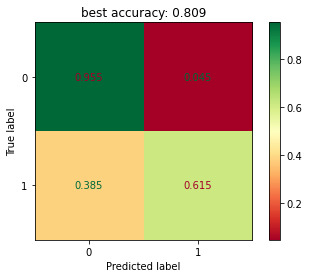

In [ ]:
#### naive bayes 
pipeMNB = make_pipeline(TfidfVectorizer(ngram_range=(1, 2)), MultinomialNB())

#display( cross_val_score(pipeMNB, X_train, y_train).mean() )

pipeMNB.fit(X_train, y_train)

plot_confusion_matrix(pipeMNB, X_test, y_test, values_format="0.3f", normalize='true', cmap="RdYlGn")
plt.title(f"best accuracy: { accuracy_score(y_test, pipeMNB.predict(X_test)):0.3f}")
plt.show()

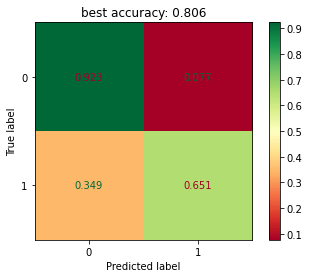

In [ ]:
#df = disaster_tweets.copy()
df = my_df_text_mining(disaster_tweets.copy(), 'text')
#### filtering numvers and special characters
#### copy for trials

X_train, X_test,\
y_train, y_test =\
 train_test_split(df["text"],
                  df["target"],
                  test_size=0.2,
                  random_state=314159,
                  stratify=df["target"])


#### naive bayes 
pipeMNB = make_pipeline(TfidfVectorizer(ngram_range=(1, 2)), MultinomialNB())

#display( cross_val_score(pipeMNB, X_train, y_train).mean() )

pipeMNB.fit(X_train, y_train)

plot_confusion_matrix(pipeMNB, X_test, y_test, values_format="0.3f", normalize='true', cmap="RdYlGn")
plt.title(f"best accuracy: { accuracy_score(y_test, pipeMNB.predict(X_test)):0.3f}")
plt.show()

In [ ]:
# marginal change: (1,1) improved, but (0,0) declined ... :( S

# Evaluation extended Modeling (weitere Spalten)

# Final Model

In [ ]:
# Performance